In [2]:
from random import sample
from itertools import combinations, permutations
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import isomorphism

## Induced subgraph isomorphism problem
Let $\mathcal{G}=(\mathcal{V},\mathcal{E})$ and $\mathcal{S}\subseteq\mathcal{V}$, $\mathcal{H}=\mathcal{G}[\mathcal{S}]$ is the subgraph induced in $\mathcal{G}$ by $\mathcal{S}$ if its edge set consists of all of the edges in $\mathcal{E}$ that have both endpoints in $\mathcal{S}$.

https://en.wikipedia.org/wiki/Induced_subgraph_isomorphism_problem

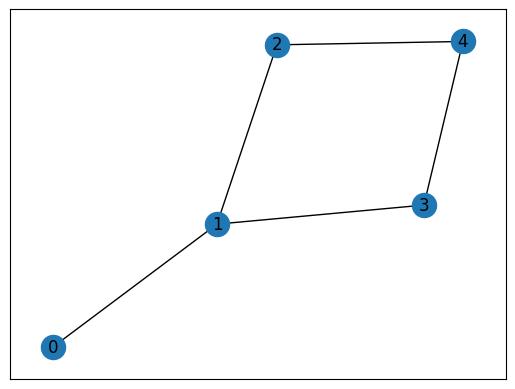

In [124]:
G = nx.Graph()
E = [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4)]
G.add_edges_from(E)
nx.draw_networkx(G)

H = nx.Graph()
E = [(0, 1), (1, 2)]
H.add_edges_from(E)

### Modular product of graphs $\mathcal{G}$ and $\mathcal{H}$
https://en.wikipedia.org/wiki/Modular_product_of_graphs

Modular product graph - Nodes: 15, Edges: 30


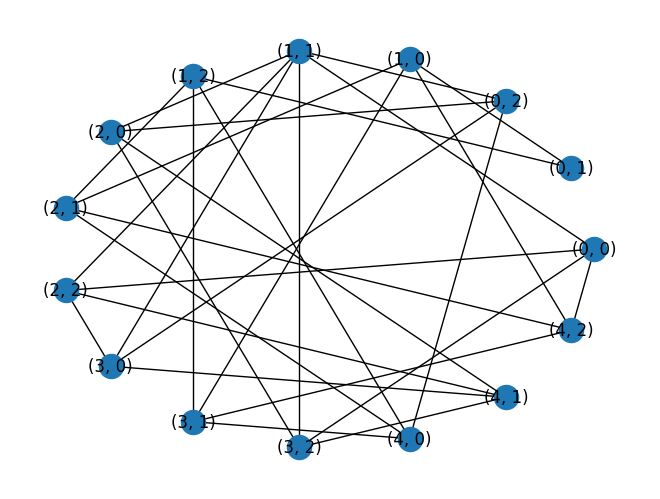

In [125]:
def modular_product(G, H):
    W = nx.Graph()
    # Create MPG: each node is a (node_G, node_H)
    for g in G.nodes():
        for h in H.nodes():
            W.add_node((g, h))

    # Add edges based on this rule
    # g1 ​!= g2​ and h1 != h2​
    # (g1,g2) in G iff (h1,h2) in H
    Wnodes = list(W.nodes())
    for i in range(len(Wnodes)):
        for j in range(i + 1, len(Wnodes)):
            g1, h1 = Wnodes[i]
            g2, h2 = Wnodes[j]

            if g1 != g2 and h1 != h2:
                # Check if edges exist in both graphs
                is_edge_G = G.has_edge(g1, g2)
                is_edge_H = H.has_edge(h1, h2)

                if is_edge_G == is_edge_H:
                    W.add_edge((g1, h1), (g2, h2))
    return W

W = modular_product(G, H)
print(f'Modular product graph - Nodes: {len(W.nodes())}, Edges: {len(W.edges())}')
nx.draw_circular(W, with_labels=True)

In [126]:
Gnodes = sorted(G.nodes())
Hnodes = sorted(H.nodes())
Wnodes = [(g, h) for g in Gnodes for h in Hnodes]
node2qubit = {w: i for i, w in enumerate(Wnodes)}
# Adjacency matrix
adjW = nx.to_numpy_array(W, nodelist=Wnodes)    #.astype(int)
edges = []
for u, v in W.edges():
    edges.append((node2qubit[u], node2qubit[v]))
assert np.sum(np.triu(adjW, k=1)) == len(edges)

In [127]:
Gorder = len(Gnodes)
Horder = len(Hnodes)
n = len(Wnodes)
# Clique hamiltonian
K = Horder
# fully connected
E = K * (K-1) / 2
qubit_grid = np.arange(n).reshape(Gorder, Horder)
qubit_grid

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

## QUBO formulation
$$H=H_A+H_B$$
Penalize if bitstring doesn't have K qubits 1:
$$H_A=A\left(K-\sum x_i\right)^2=A\left(K^2-(2K-1)\sum x_i+2\sum_{i<j}x_ix_j\right)$$
Penalize if clique is not fully connected:
$$H_B=B\left(E-\sum_{(ij)\in\mathcal{E}}x_ix_j\right)$$

In [128]:
def H_A(num_qubits, A, K):
    # const term
    # c = A * K * K
    # Linear terms
    h = {}
    for i in range(num_qubits):
        h[i] = -A * (2 * K - 1)
    # Quadratic terms
    J = {}
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            J[(i, j)] = 2 * A
    return h, J

def H_B(edges, num_qubits, B):
    E = set(edges)
    J = {}
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            if (i, j) not in E:
                J[(i, j)] = B
    return J

In [129]:
# Penalties
A = 1.5
B = 3

h, J = H_A(n, A, K)
J_B = H_B(edges, n, B)
for (i, j), val in J_B.items():
    if (i, j) in J:
        J[(i, j)] += val
    else:
        J[(i, j)] = val

### Qubo to Ising
$$x_i=\frac{1-Z_i}{2}$$

In [130]:
def qubo2ising(hQ, JQ):
    h = {i: 0 for i in range(len(hQ))}
    J = {}
    E_0 = 0

    # Linear QUBO terms
    # x_i = (1 - Z_i) / 2
    for i, w in hQ.items():
        E_0 += w * 0.5
        h[i] -= w * 0.5

    # Quadratic QUBO terms
    # x_i * x_j = (1 - Z_i - Z_j + Z_i*Z_j) / 4
    for (i, j), w in JQ.items():
        E_0 += w * 0.25
        h[i] -= w * 0.25
        h[j] -= w * 0.25
        J[(i, j)] = w * 0.25

    return h, J, E_0

h, J, E_0 = qubo2ising(h, J)
offset = A * (K*K + n*(1-2*K)/2 + n*(n-1)/4)
offset += B * (n*(n-1)/2 - W.number_of_edges()) / 4
offset

92.25

In [111]:
%%capture
!pip install qiskit[visualization]
!pip install qiskit-ibm-runtime
!pip install qiskit_aer

In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp

In [131]:
ansatz = QuantumCircuit(n)

# Pseudo Dicke state preparation
g_nodes = sample(Gnodes, K)
for j, i in enumerate(g_nodes):
    qubit = node2qubit[(i, j)]
    ansatz.x(qubit)
for i in range(n - 1):
    # Move '1' from qubit i to i+1
    # while keeping the total number of 1s constant.
    ansatz.rxx(np.pi/4, i, i+1)
    ansatz.ryy(np.pi/4, i, i+1)

# Parameters
L = 3
beta = [Parameter(f'β_{l}') for l in range(L)]
gamma = [Parameter(f'γ_{l}') for l in range(L)]

In [132]:
def U_N(q, qubit_grid, beta_l, H):
    #q.barrier(label='U_N')
    # Group nodes of H by orbits
    degrees = dict(H.degree())
    orbits = {}
    for node, deg in degrees.items():
        if deg not in orbits:
            orbits[deg] = []
        orbits[deg].append(node)

    for row in qubit_grid:
        for deg, nodes in orbits.items():
            # Rotate nodes in orbit
            for i in nodes:
                q.rx(2 * beta_l, row[i])

            # Swap leaves to preserve symmetry
            if len(nodes) > 1:
                for i, j in combinations(nodes, 2):
                    u, v = row[i], row[j]
                    q.rxx(beta_l, u, v)
                    q.ryy(beta_l, u, v)

def H_G(h, J, n):
    data = []
    coeffs = []

    # Add Z terms (Biases)
    for i, w in h.items():
        if w == 0: continue
        pauli = ['I'] * n
        pauli[i] = 'Z'
        data.append(''.join(pauli[::-1]))
        coeffs.append(w)

    # Add ZZ terms (Interactions)
    for (u, v), w in J.items():
        if w == 0: continue
        pauli = ['I'] * n
        pauli[u] = 'Z'
        pauli[v] = 'Z'
        data.append(''.join(pauli[::-1]))
        coeffs.append(w)

    return SparsePauliOp(data, coeffs)

def U_G(q, h, J, gamma_l):
    #q.barrier(label='U_G')
    # Apply RZ for single-qubit biases
    for i, w in h.items():
        q.rz(2 * gamma_l * w, i)
    # Apply RZZ for two-qubit interactions
    for (u, v), w in J.items():
        q.rzz(2 * gamma_l * w, u, v)

In [133]:
for l in range(L):
    U_G(ansatz, h, J, gamma[l])
    U_N(ansatz, qubit_grid, beta[l], H)

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session, SamplerV2 as Sampler
from scipy.optimize import minimize

In [17]:
api = ''
crn = ''

In [49]:
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=api,
    instance=crn
)
backend = AerSimulator()

qiskit_runtime_service._discover_account:WARNING:2026-01-31 01:48:15,593: Loading account with the given token. A saved account will not be used.


In [134]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian = H_G(h, J, n)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [135]:
print(f'{ansatz_isa.depth()=}')
print(f'{ansatz_isa.size()=}')

ansatz_isa.depth()=89
ansatz_isa.size()=466


In [136]:
cost_history = {
    'prev_vector': None,
    'iters': 0,
    'costs': [],
}

# Return zero-point energy
def cost(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    job = estimator.run(pubs=[pub])
    # Expectation value
    E_0 = job.result()[0].data.evs[0]

    cost_history['iters'] += 1
    cost_history['prev_vector'] = params
    cost_history['costs'].append(E_0+offset)
    print(f"Iter {cost_history['iters']} -> ^E_0 = {E_0+offset} -- ^θ = {params}")

    return E_0 + offset

In [137]:
theta_0 = np.random.uniform(0., 0.1, len(ansatz.parameters))

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost,
        theta_0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method='COBYLA',
        tol=1e-3,
        options={'maxiter': 200, 'rhobeg': 0.4},
    )
    print(f'θ = {res.x}')

Iter 1 -> ^E_0 = 7.754099999999951 -- ^θ = [0.05185548 0.01104071 0.07998717 0.03720222 0.02906158 0.01579971]
Iter 2 -> ^E_0 = 35.29199999999998 -- ^θ = [0.45185548 0.01104071 0.07998717 0.03720222 0.02906158 0.01579971]
Iter 3 -> ^E_0 = 39.330149999999996 -- ^θ = [0.05185548 0.41104071 0.07998717 0.03720222 0.02906158 0.01579971]
Iter 4 -> ^E_0 = 40.12770000000001 -- ^θ = [0.05185548 0.01104071 0.47998717 0.03720222 0.02906158 0.01579971]
Iter 5 -> ^E_0 = 7.927950000000024 -- ^θ = [0.05185548 0.01104071 0.07998717 0.43720222 0.02906158 0.01579971]
Iter 6 -> ^E_0 = 6.70035 -- ^θ = [0.05185548 0.01104071 0.07998717 0.03720222 0.42906158 0.01579971]
Iter 7 -> ^E_0 = 6.664199999999994 -- ^θ = [0.05185548 0.01104071 0.07998717 0.03720222 0.42906158 0.41579971]
Iter 8 -> ^E_0 = 12.090749999999986 -- ^θ = [-0.15614163 -0.22745704 -0.16453457  0.03588911  0.43702068  0.41607275]
Iter 9 -> ^E_0 = 6.955800000000025 -- ^θ = [0.07850742 0.02135313 0.08707246 0.17457705 0.57140364 0.41594598]
Ite

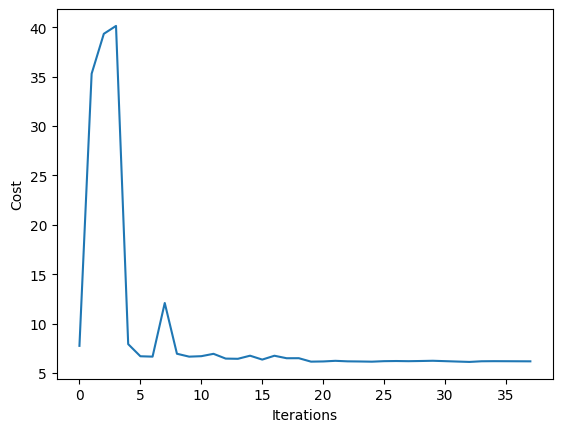

In [138]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 171)
ax.plot(range(cost_history["iters"]), cost_history["costs"], label="VQE")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [139]:
with Session(backend=backend) as session:
    sampler = Sampler(mode=session)
    # Use the best parameters
    qc_measured = ansatz_isa.copy()
    qc_measured.measure_all()
    best_pub = (qc_measured, [res.x])
    result = sampler.run([best_pub]).result()

    # Get the bitstring with the highest probability
    counts_int = result[0].data.meas.get_int_counts()
    counts_bin = result[0].data.meas.get_counts()
    shots = sum(counts_int.values())
    final_distribution_int = {key: val / shots for key, val in counts_int.items()}
    final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
    print(f"Top 5 bitstrings: ")
    top_5 = sorted(counts_bin.items(), key=lambda x: x[1], reverse=True)[:5]
    print(top_5)

Top 5 bitstrings: 
[('001100001000000', 122), ('000110001000000', 120), ('100100001000000', 72), ('001010001000000', 63), ('000110010000000', 56)]


In [140]:
def decode_bitstring(bitstring, node2qubit):
    qubit2node = {v: k for k, v in node2qubit.items()}

    bits = bitstring[::-1]

    mappings = []
    for i, bit in enumerate(bits):
        if bit == '1':
            g_node, h_node = qubit2node[i]
            mappings.append((g_node, h_node))

    return mappings

matches = [decode_bitstring(bs[0], node2qubit) for bs in top_5]

print('Top bitstring')
for u, v in matches[0]:
    print(f"G Node {u} maps to H node {v}")

Top bitstring
G Node 2 maps to H node 0
G Node 3 maps to H node 2
G Node 4 maps to H node 0


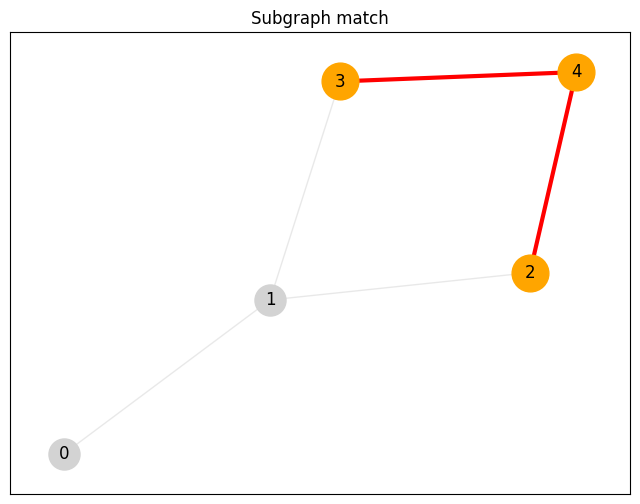

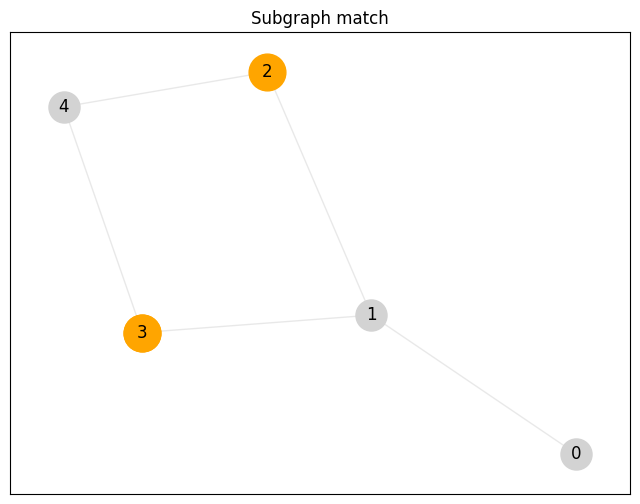

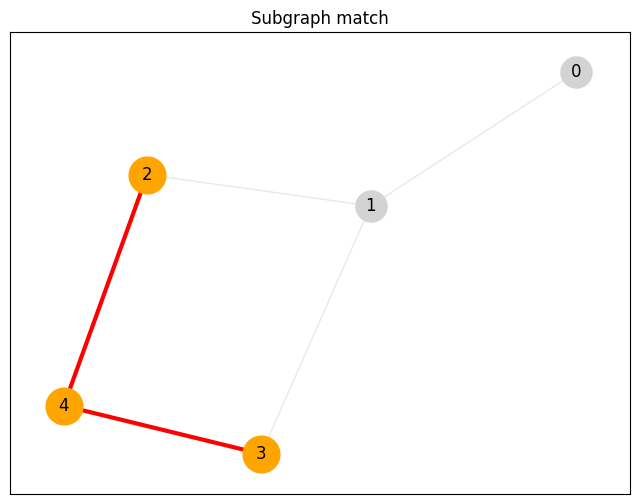

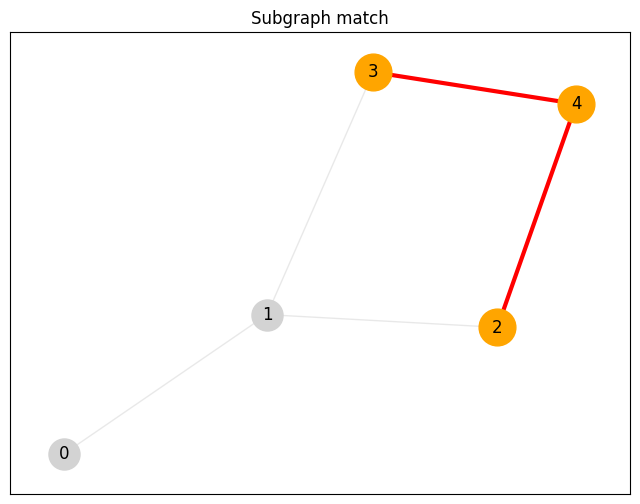

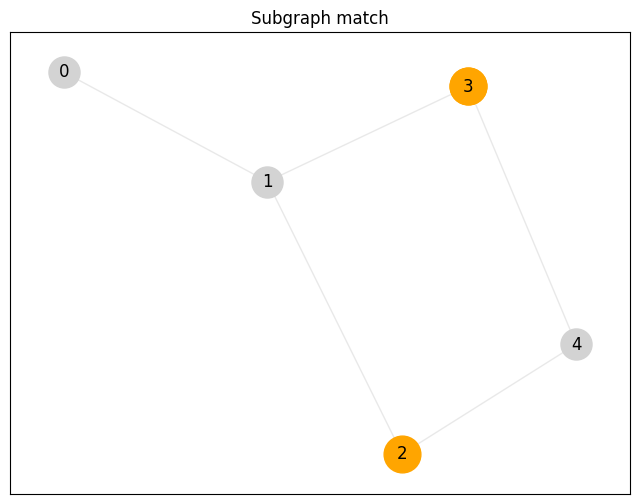

In [141]:
def plot_subgraph(G, selected_nodes, title='Subgraph match'):
    pos = nx.spring_layout(G)

    plt.figure(figsize=(8, 6))
    # Draw all nodes and edges in gray
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.5)
    nx.draw_networkx_labels(G, pos)

    # Highlight the nodes found
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_color='orange', node_size=700)

    # Highlight the edges between those nodes
    sub_edges = G.subgraph(selected_nodes).edges()
    nx.draw_networkx_edges(G, pos, edgelist=sub_edges, edge_color='red', width=3)

    plt.title(title)
    plt.show()

for match in matches:
    plot_subgraph(G, list(zip(*match))[0])

In [142]:
def verify_isomorphism(mapping, G, H):
    assert len(mapping) == len(H.nodes())

    # Extract the nodes from G that the quantum circuit selected
    g_nodes = [pair[0] for pair in mapping]

    # Create the induced subgraph from G
    subgraph_G = G.subgraph(g_nodes)

    # Check if the induced subgraph is isomorphic to H
    ismags = nx.isomorphism.ISMAGS(subgraph_G, H)
    if ismags.is_isomorphic():
        print("Success! The nodes form a valid induced subgraph isomorphism.")
    else:
        print("Failure: Nodes do not match H.")

for match in matches:
    verify_isomorphism(match, G, H)

Success! The nodes form a valid induced subgraph isomorphism.
Failure: Nodes do not match H.
Success! The nodes form a valid induced subgraph isomorphism.
Success! The nodes form a valid induced subgraph isomorphism.
Failure: Nodes do not match H.
